<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/07-autoencoding-and-self-supervision/01_pca_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PCA Autoencoder

In this notebook, we shows that bread-andbutter
principal component analysis (PCA) works by secretly being an autoencoder.

We’ll make small changes to a PyTorch version of PCA to change it into a fully fledged
autoencoding neural network. 

As we make an autoencoding network larger, it becomes
more important to constrain it well, which we demonstrate with the denoising strategy.

Finally we apply these concepts to sequential models like RNNs, which gives the autoregressive model.

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from idlmam import train_network, Flatten, View, weight_reset, set_seed

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

Now we want to create a wrapper for the MNIST datasets. 

Why? Because the default MNIST dataset will return data in pairs `(x, y)` for the input and label, respectively. 

But in our case, the input is the label because we are trying to predict the output from the input.

So we extend the PyTorch Dataset class to take the original tuple `x, y` and instead return a tuple `x, x`.

In [6]:
class AutoEncoderDataset(Dataset):
  """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs."""
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    x, y = self.dataset.__getitem__(idx)
    # just throw away the original label.
    return x, x

In [ ]:
B = 128

train_data = AutoEncoderDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncoderDataset(test_data_xy)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data_xx, batch_size=B)

##PCA encoder and decoder

Let’s define some basic hyperparameters.

In [8]:
D = 28 * 28       # input size
n = 2             # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

Let's define `TransposeLinear` layer that will implement the Transpose
operation $W^T$. 

The matrix to transpose $W$ must be passed in as the `linear_layer` in the
constructor. 

This way, we can share weights between an original `nn.Linear` layer and
this transposed version of that layer.

In [9]:
class TransposeLinear(nn.Module):
  def __init__(self, linear_layer, bias=True):
    """
    linearLayer: is the layer that we want to use the transpose of to produce the output of this layer. 
                  So the Linear layer represents W, and this layer represents W^T. 
                  This is accomplished via weight sharing by re-using the weights of linearLayer
    bias: if True, we will crease a new bias term b that is learned separately from what is in linearLayer. 
          If false, we will not use any bias vector
    """
    super().__init__()

    # create a new variable weight to store a _reference_ to the original weight term.
    self.weight = linear_layer.weight

    if bias:
      # create a new bias vector
      self.bias = nn.Parameter(torch.Tensor(linear_layer.weight.shape[1]))
    else:
      # So if we want the bias term to exist, but be  potentially unused
      self.register_parameter("bias", None)

  def forward(self, x):
    # performs a linear transform when given an input (we use the transpose of our weights) and a bias (if None, it knows to not do anything)
    return F.linear(x, self.weight.t(), self.bias)

Note that because the input comes in as an image with shape `(B, 1, 28, 28)`, and we
are using linear layers, we first need to flatten the input into a vector of shape `(B, 28*28)`.

But in the decode step, we want to have the same shape as the original data.

In [10]:
# Since we will share the weights of the linear layer, lets define it separately
linear_layer = nn.Linear(D, n, bias=False)

# The encoder just falltens and then uses the linear layer
pca_encoder = nn.Sequential(
  nn.Flatten(),
  linear_layer
)

# The decoder uses our TransposeLinear layer + the now shared linearLayer object 
pca_decoder = nn.Sequential(
  TransposeLinear(linear_layer, bias=False),
  View(-1, 1, 28, 28)   # Shape the data back to it's original form
)

# Define a final PCA model that is the sequence of an encoder, followed by a decoder
pca_model = nn.Sequential(
  pca_encoder,
  pca_decoder
)

To make this autoencoder truly PCA, we
need to add the $WW^T = I$ constraint. 

This constraint has a name: **orthogonality**.

In [11]:
nn.init.orthogonal_(linear_layer.weight)

Parameter containing:
tensor([[-0.0063, -0.0112, -0.0474,  ...,  0.0428,  0.0234, -0.0159],
        [-0.0503,  0.0659, -0.0364,  ...,  0.0330,  0.0096,  0.0341]],
       requires_grad=True)

We take a common and simple
approach to encourage orthogonality.

This is done by converting the
equality $WW^T=I$ into a penalty or regularizer $||WW^T - I||_2^2$.

This works because if the
penalty is 0, then $W$ is orthogonal; and if the penalty is nonzero, it will increase the loss,
and thus gradient decent will try to make $W$ more orthogonal.

In [12]:
# Original loss function
mse_loss = nn.MSELoss()

# our PCA loss function
def mse_with_orthogonal_loss(x, y):
  # Grabing W from the linearLayer object
  W = linear_layer.weight
  # The identity matrix that is the target for the regularized
  I = torch.eye(W.shape[0]).to(device)
  # compute the original loss
  normal_loss = mse_loss(x, y)
  # compute the regularizer penalty 
  regularization_loss = 0.1 * mse_loss(torch.mm(W, W.t()), I)
  # return the sum of the two losses
  return normal_loss + regularization_loss

Now we can train this PCA model the same way we have been training other neural networks.

In [13]:
train_network(pca_model, mse_with_orthogonal_loss, training_loader, epochs=10, test_loader=testing_loader, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,15.405883,0.064485,0.058074
1,1,21.015307,0.058053,0.057870
2,2,26.647874,0.057895,0.057795
3,3,32.282968,0.057886,0.057814
4,4,37.908022,0.057886,0.057857
5,5,43.580058,0.057889,0.057818
6,6,49.267677,0.057888,0.057843
7,7,54.898914,0.057887,0.057811
8,8,61.502282,0.057886,0.057792
9,9,67.117205,0.057889,0.057857


###Visualizing PCA results

Let's copy the labels
so that we can look at our results compared to the ground truth of the MNIST test data.

In [14]:
def encode_batch(encoder, dataset_to_encode):
  # Create space to store the results
  projected = []
  labels = []

  # Switch to eval mode
  encoder = encoder.eval()
  # Switching to CPU mode for simplicty, but you don't have to. 
  encoder = encoder.cpu()

  # We don't want to train, so torch.no_grad!
  with torch.no_grad():
    for x, y in DataLoader(dataset_to_encode, batch_size=128):
      # encode the original data
      z = encoder(x.cpu())
      # store the encoded version & label
      projected.append(z.numpy())
      labels.append(y.cpu().numpy().ravel())
  # Turn the results into single large numpy arrays
  projected = np.vstack(projected)
  labels = np.hstack(labels)
  return projected, labels

# Now lets project our data
projected, labels = encode_batch(pca_encoder, test_data_xy)

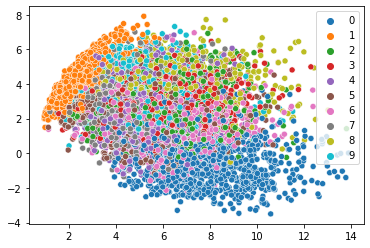

In [15]:
sns.scatterplot(x=projected[:, 0], y=projected[:, 1], 
            hue=[str(l) for l in labels], 
            hue_order=[str(i) for i in range(10)],
            legend="full")

Let's plot the original input x on the left and the encoded-decoded version on
the right.

In [16]:
def show_encoded_decoded_image(encode_decode, x):
  encode_decode = encode_decode.eval()
  encode_decode = encode_decode.cpu()
  with torch.no_grad():
    x_recon = encode_decode(x.cpu())
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(x.numpy()[0, :])
  axarr[1].imshow(x_recon.numpy()[0, 0, :])

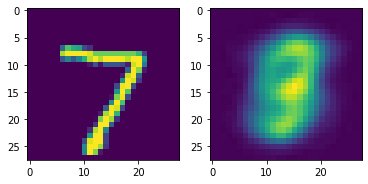

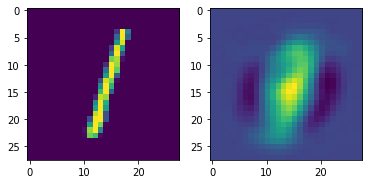

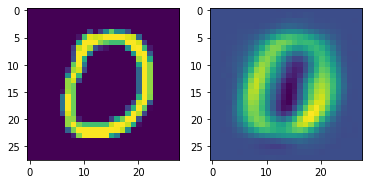

In [17]:
# Showing the input (left) and output (right) for three data points
show_encoded_decoded_image(pca_model, test_data_xy[0][0])
show_encoded_decoded_image(pca_model, test_data_xy[2][0])
show_encoded_decoded_image(pca_model, test_data_xy[10][0])

These results match what we expected based on the 2D plot. The 0 and 1 classes look
kind of like a 1 and 0 after we encode and decode them. The 7 . . . not so much.

Why? Well, we are converting 784 dimensions down to 2. 

That’s a lot of information
compression—much more than we can reasonably expect poor PCA to be able to do.

###A simple nonlinear PCA

We
can add a single nonlinearity and remove the weight sharing to turn this into a small
nonlinear autoencoder.

In [18]:
# First the encoder is augmented by a Tanh non-linearity
pca_nonlinear_encoder = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D, n),
  nn.Tanh()  # The only real change, ading a non-linear operation at the end
)

# The decoder gets its own Linear layer now, making it look more like a normal network
pca_nonlinear_decoder = nn.Sequential(
  nn.Linear(n, D),      # We are no longer tying the weights for simplicity 
  View(-1, 1, 28, 28)   # Shape the data back to it's original form
)

# Define a final PCA model that is the sequence of an encoder, followed by a decoder
pca_nonlinear = nn.Sequential(
  pca_nonlinear_encoder,
  pca_nonlinear_decoder
)

Since we are no longer sharing weights between the encoder and decoder, we do not
care if the weights are orthogonal. 

So when we train this model, we use the normal MSE
loss:

In [19]:
train_network(pca_nonlinear, mse_loss, training_loader, epochs=10, test_loader=testing_loader, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,5.897728,0.132321,0.069795
1,1,11.717652,0.066759,0.066217
2,2,17.395854,0.065827,0.065688
3,3,23.173438,0.065187,0.064853
4,4,28.927763,0.064133,0.063480
5,5,34.678253,0.062394,0.061380
6,6,40.911310,0.060291,0.059420
7,7,46.804737,0.058735,0.058223
8,8,52.613922,0.057855,0.057579
9,9,58.403680,0.057368,0.057194


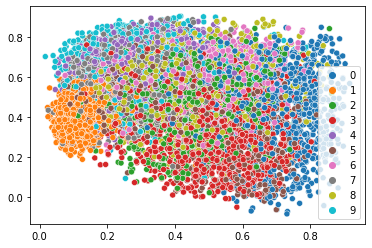

In [20]:
projected, labels = encode_batch(pca_nonlinear_encoder, test_data_xy)
sns.scatterplot(x=projected[:, 0], y=projected[:, 1], 
            hue=[str(l) for l in labels], 
            hue_order=[str(i) for i in range(10)],
            legend="full")

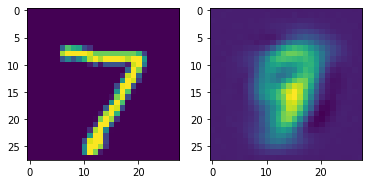

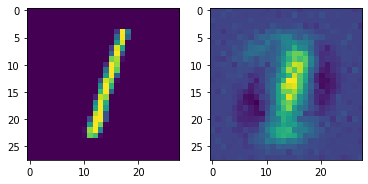

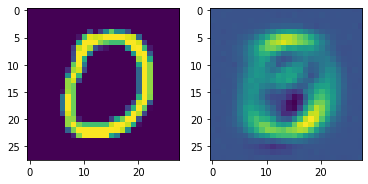

In [21]:
# Showing the input (left) and output (right) for three data points
show_encoded_decoded_image(pca_nonlinear, test_data_xy[0][0])
show_encoded_decoded_image(pca_nonlinear, test_data_xy[2][0])
show_encoded_decoded_image(pca_nonlinear, test_data_xy[10][0])

Now we can try to make
bigger changes to get a better result. 

As a theme of deep learning, if we make this model
deeper by adding more layers, we should be able to successfully improve the results.

##Autoencoding neural networks

PCA is a very popular method for dimensionality reduction and visualization, and
any situation where you would use PCA is one where you may want to instead use an
autoencoding network.

Autoencoding networks are also useful for outlier detection.An autoencoder can detect outliers by looking at how well it reconstructed the input. 

If you can reconstruct the input well, the data probably
looks like normal data you’ve seen. If you cannot successfully reconstruct the input, it is
probably unusual and thus an outlier.

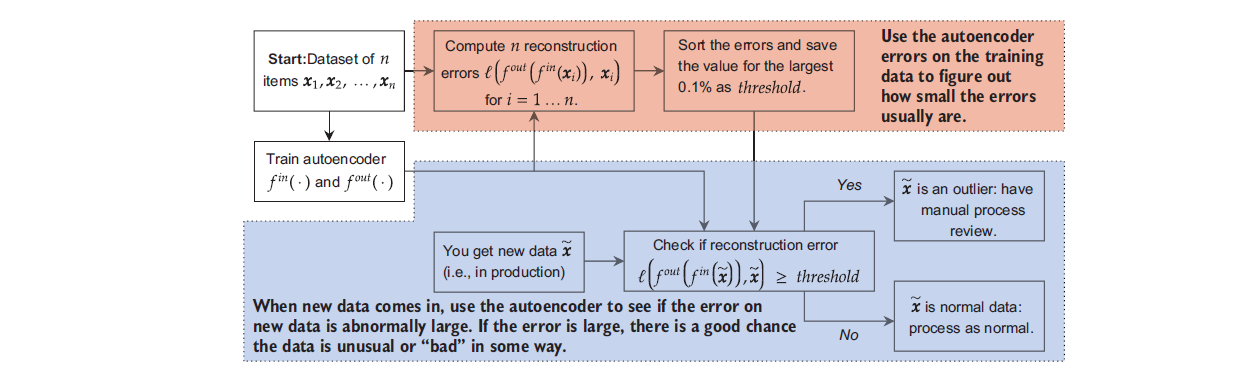

Now let’s talk about how to set up a deep learning-based autoencoder. 

The standard
approach is to make a symmetric architecture between the encoder and decoder:
keep the same number of layers in each and put them in the reverse order (encoder
goes from big to small, and decoder goes from small to big). 

We also use a bottleneck
style encoder, meaning the layers have progressively fewer neurons.

The bottleneck in the encoder is important, though. 

Just as PCA did, by pushing
down to a smaller representation, we make it impossible for the network to cheat and
learn the naive solution of immediately returning the input as the output.

Instead, the
network must learn to identify high-level concepts like “there is a circle located at the
center,” which could be used for encoding (and then decoding) the numbers 6 and 0.

By learning multiple high-level concepts, the network is forced to start learning useful
representations.

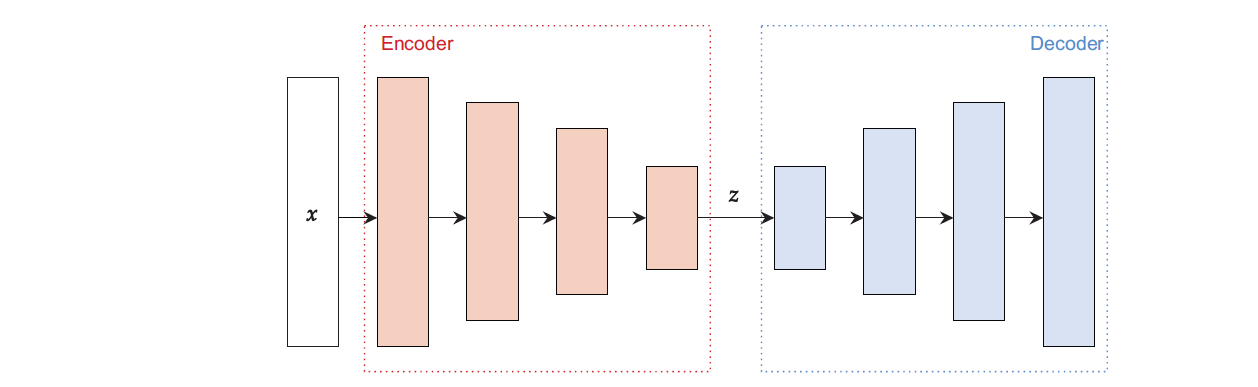

To start, let’s define another helper function getLayer
that creates a single hidden layer for us to place in a network.

In [22]:
def get_layer(in_size, out_size):
  """
  in_size: how many neurons/features are coming into this layer
  out_size: how many neurons/outputs this hidden layer should produce
  """
  # Organize the conceptual "block" of a hidden layer into a Sequential object
  return nn.Sequential(
    nn.Linear(in_size, out_size),
    nn.BatchNorm1d(out_size),
    nn.ReLU()
  )

It uses a simple strategy of decreasing the number
of neurons in each hidden layer by a fixed pattern.

In this case, we divide the number of neurons by 2, then 3, then 4, and so on until the last layer of the decoder, where we
jump straight to the target size $\hat D$. 

The pattern used to decrease the number of layers is
not that important, as long as the size of the layers consistently decreases:

In [23]:
# Dividing by 2, 3, 4, is one of many patterns that could have been used
auto_encoder = nn.Sequential(
  nn.Flatten(),
  # Each of these layers has a smaller output size than the previous
  get_layer(D, D // 2),
  get_layer(D // 2, D // 3),
  get_layer(D // 3, D // 4),
  # Jump down to the target dimension
  get_layer(D // 4, n)
)

# Decoder will do the same layers/sizes in reverse now to be symmetric 
auto_decoder = nn.Sequential(
  # Each layer now increases in size because we are in the decoder
  get_layer(n, D // 4),
  get_layer(D // 4, D // 3),
  get_layer(D // 3, D // 2),
  get_layer(D // 2, D),
  # Reshape to match the original shape
  View(-1, 1, 28, 28)
)

# Combine into a deep auto encoder
auto_encoder_decoder = nn.Sequential(
  auto_encoder,
  auto_decoder
) 

In [24]:
# Let's train this model
train_network(auto_encoder_decoder, mse_loss, training_loader, epochs=10, test_loader=testing_loader, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,8.379846,0.070091,0.051406
1,1,16.781327,0.050511,0.047137
2,2,25.196057,0.047720,0.045423
3,3,33.454636,0.045830,0.043454
4,4,42.504222,0.044533,0.042579
5,5,50.905296,0.043662,0.041660
6,6,59.525118,0.042839,0.040536
7,7,67.989396,0.042197,0.040044
8,8,76.499779,0.041611,0.039421
9,9,87.725803,0.041043,0.039202


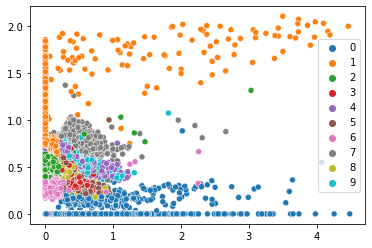

In [25]:
projected, labels = encode_batch(auto_encoder, test_data_xy)
sns.scatterplot(x=projected[:, 0], y=projected[:, 1], 
            hue=[str(l) for l in labels], 
            hue_order=[str(i) for i in range(10)],
            legend="full")

This is also one way to use autoencoders to explore unknown data. If we did not know
the class labels, we might have concluded from this projection that there were likely at
least two to four different subpopulations in the data.

We can also look at some examples of the encode-decode cycle. Unlike before, the
reconstructions are now crisp, with much less blur. But it’s not perfect: class 4 is usually
hard to separate from others and has low-quality reconstructions:

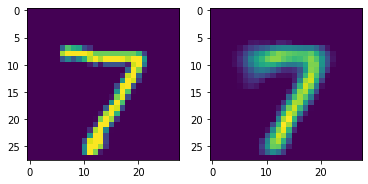

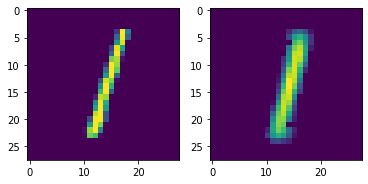

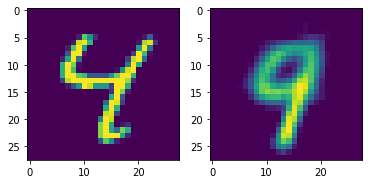

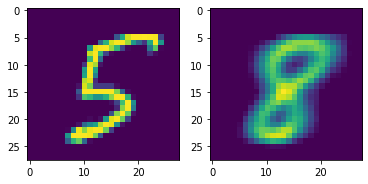

In [26]:
# Showing the input (left) and output (right) for three data points
show_encoded_decoded_image(auto_encoder_decoder, test_data_xy[0][0])
show_encoded_decoded_image(auto_encoder_decoder, test_data_xy[2][0])
show_encoded_decoded_image(auto_encoder_decoder, test_data_xy[6][0])
show_encoded_decoded_image(auto_encoder_decoder, test_data_xy[23][0])

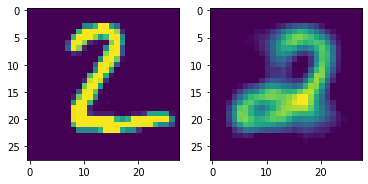

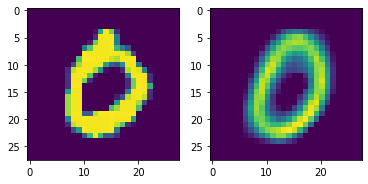

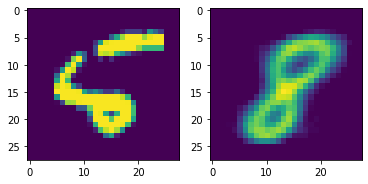

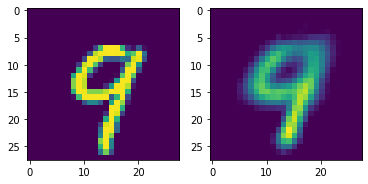

In [27]:
show_encoded_decoded_image(auto_encoder_decoder, test_data_xy[1][0])
show_encoded_decoded_image(auto_encoder_decoder, test_data_xy[3][0])
show_encoded_decoded_image(auto_encoder_decoder, test_data_xy[8][0])
show_encoded_decoded_image(auto_encoder_decoder, test_data_xy[12][0])

The reconstruction
is different from the input, and the goal was to exactly reconstruct the input.

Our goal was to learn a useful representation of the data
without needing to know the data labels.

But the example of the digit 4 is a bad failure case. The network reconstructed a
completely different digit because the restriction is too strong : the network was forced
down to just two dimensions and couldn’t learn all the complexity in the data with such
little space. This meant forcing out the concept of a 4.